<a href="https://colab.research.google.com/github/KristynaPijackova/Exercises/blob/main/MLF_Miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification of wireless transmitters** 📻

## Task Description

Classification of wireless transmitters based on measured data with MLP and SVM.

Dataset contains 19200 samples and 12 features in total.

**Features to use for training**: 
    
*   cfo_means - carrier frequency offsst between Tx and Rx - measured on vector spectral analyzer
*   cfo_demod - CFO after demodulation
*   gain_imb - gain imbalance
*   iq_imb - combination of gain and quadrature imbalance
*   or_off - origin offset - DC offset
*   quadr_err - quadrature error imbalance
*   ph_err - represents phase differenc between Y(n) and X(n)
*   mag_err - magnitude error between Y(n) and X(n)
*   evm - error vector mahcine - RMS error between Y(n) and X(n) constellation points in QAM

**Features NOT to use for training**: 
    
*   m_power - measured signal power
*   Tosc - temperature of SDR at local oscilator
*   Tmix - temperature of SDR at RF mixer


Notebook by: **Kristyna Pijackova** 🌼

# Code

## Install and Import Libraries 📚

Keras Tuner for HP search

In [ ]:
!pip install keras-tuner --upgrade

Pandas Profiling for fast EDA

In [ ]:
!pip install pandas-profiling

Import Libraries

In [81]:
import numpy as np
import pandas as pd

from sklearn import preprocessing

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import keras_tuner
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt

# Get Data 💾

In [19]:
# x_test.csv
!gdown 1ddDzOrmp_yGQAWVvVj-YH_j3kb60ZntD
# x_train.csv
!gdown 1qBSO4ANaGDQ_Ka71cGnSKUfEizW_37ID
# y_train.csv
!gdown 1uxlSYwIH7UPrYvTNbl4yZCt6HzlOr10X

Downloading...
From: https://drive.google.com/uc?id=1ddDzOrmp_yGQAWVvVj-YH_j3kb60ZntD
To: /content/x_test.csv
100% 551k/551k [00:00<00:00, 57.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qBSO4ANaGDQ_Ka71cGnSKUfEizW_37ID
To: /content/x_train.csv
100% 2.21M/2.21M [00:00<00:00, 221MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uxlSYwIH7UPrYvTNbl4yZCt6HzlOr10X
To: /content/y_train.csv
100% 127k/127k [00:00<00:00, 74.5MB/s]


## Load Data 🔄

Load data into dataframes

In [45]:
# x and y train
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')

# x test
x_test = pd.read_csv('x_test.csv')


Quick look at the data

In [46]:
x_train.head(5)

Unnamed: 0   cfo_demod  gain_imb     iq_imb     or_off  quadr_err  \
0           0  592.234802  0.048079 -35.082729 -28.560846   1.993170   
1           1 -103.302032 -0.019917 -29.946953 -35.798664  -3.642311   
2           2 -582.331299  0.036379 -32.096672 -31.905628   2.835839   
3           3 -630.611267  0.063928 -38.216297 -30.084171   1.346316   
4           4 -415.526978 -0.055761 -29.180740 -36.601025  -3.963526   

    m_power    ph_err   mag_err       evm  Tosc  Tmix  
0 -0.499721  1.107926  1.507550  2.423943  39.9  47.6  
1 -0.928193  1.236059  2.741568  3.458056  14.8  23.1  
2 -1.272485  1.282163  2.140096  3.013522  42.5  48.6  
3 -0.596438  1.154848  1.093465  2.254514  26.1  35.4  
4  0.113055  1.498889  3.608737  4.286684  24.2  40.8

In [47]:
y_train.head(5)

id  target
0   0       5
1   1       1
2   2       6
3   3       3
4   4       2

In [48]:
x_test.head(5)

Unnamed: 0   cfo_demod  gain_imb     iq_imb     or_off  quadr_err  \
0           0  516.312866  0.055910 -34.748932 -28.086121   2.064618   
1           1 -452.875031  0.091061 -31.916044 -29.092400   2.843033   
2           2  543.581909  0.067271 -34.311523 -28.395725   2.160502   
3           3 -711.415710  0.001931 -30.205307 -35.895462  -3.537908   
4           4 -912.994873  0.054695 -31.485973 -33.110847   3.031799   

    m_power    ph_err   mag_err       evm  Tosc  Tmix  
0 -0.382014  1.166067  1.528550  2.541858  42.7  50.0  
1 -0.585288  1.242625  2.044024  2.974349  28.8  37.3  
2 -0.272394  1.031588  1.615977  2.427548  29.3  37.8  
3 -1.061280  1.260278  2.586169  3.350533  31.9  42.6  
4 -0.778807  1.343741  2.222488  3.199810  18.3  24.6

Drop columns we cannot or do not want to use

In [49]:
columns_to_drop = ['Unnamed: 0', 'm_power', 'Tosc', 'Tmix']
x_train = x_train.drop(columns_to_drop, axis=1)
x_test = x_test.drop(columns_to_drop, axis=1)

## Exploratory Data Analysis 🎓

Join x_train and y_train data for common analysis

In [50]:
df = y_train.join(x_train)

Drop index column of the dataframe

In [51]:
df = df.drop(['id'], axis=1)
df.head(5)

target   cfo_demod  gain_imb     iq_imb     or_off  quadr_err    ph_err  \
0       5  592.234802  0.048079 -35.082729 -28.560846   1.993170  1.107926   
1       1 -103.302032 -0.019917 -29.946953 -35.798664  -3.642311  1.236059   
2       6 -582.331299  0.036379 -32.096672 -31.905628   2.835839  1.282163   
3       3 -630.611267  0.063928 -38.216297 -30.084171   1.346316  1.154848   
4       2 -415.526978 -0.055761 -29.180740 -36.601025  -3.963526  1.498889   

    mag_err       evm  
0  1.507550  2.423943  
1  2.741568  3.458056  
2  2.140096  3.013522  
3  1.093465  2.254514  
4  3.608737  4.286684

In [52]:
eda = ProfileReport(df)
eda

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Output of the data analysis can be seen in attached file 'eda.html'

- we can see that there are no values missing, NaN nor duplicates
- we can observe some high correlation between the target and gain_imb, or_off, quadr_err, cfo_demod, mag_err and evm

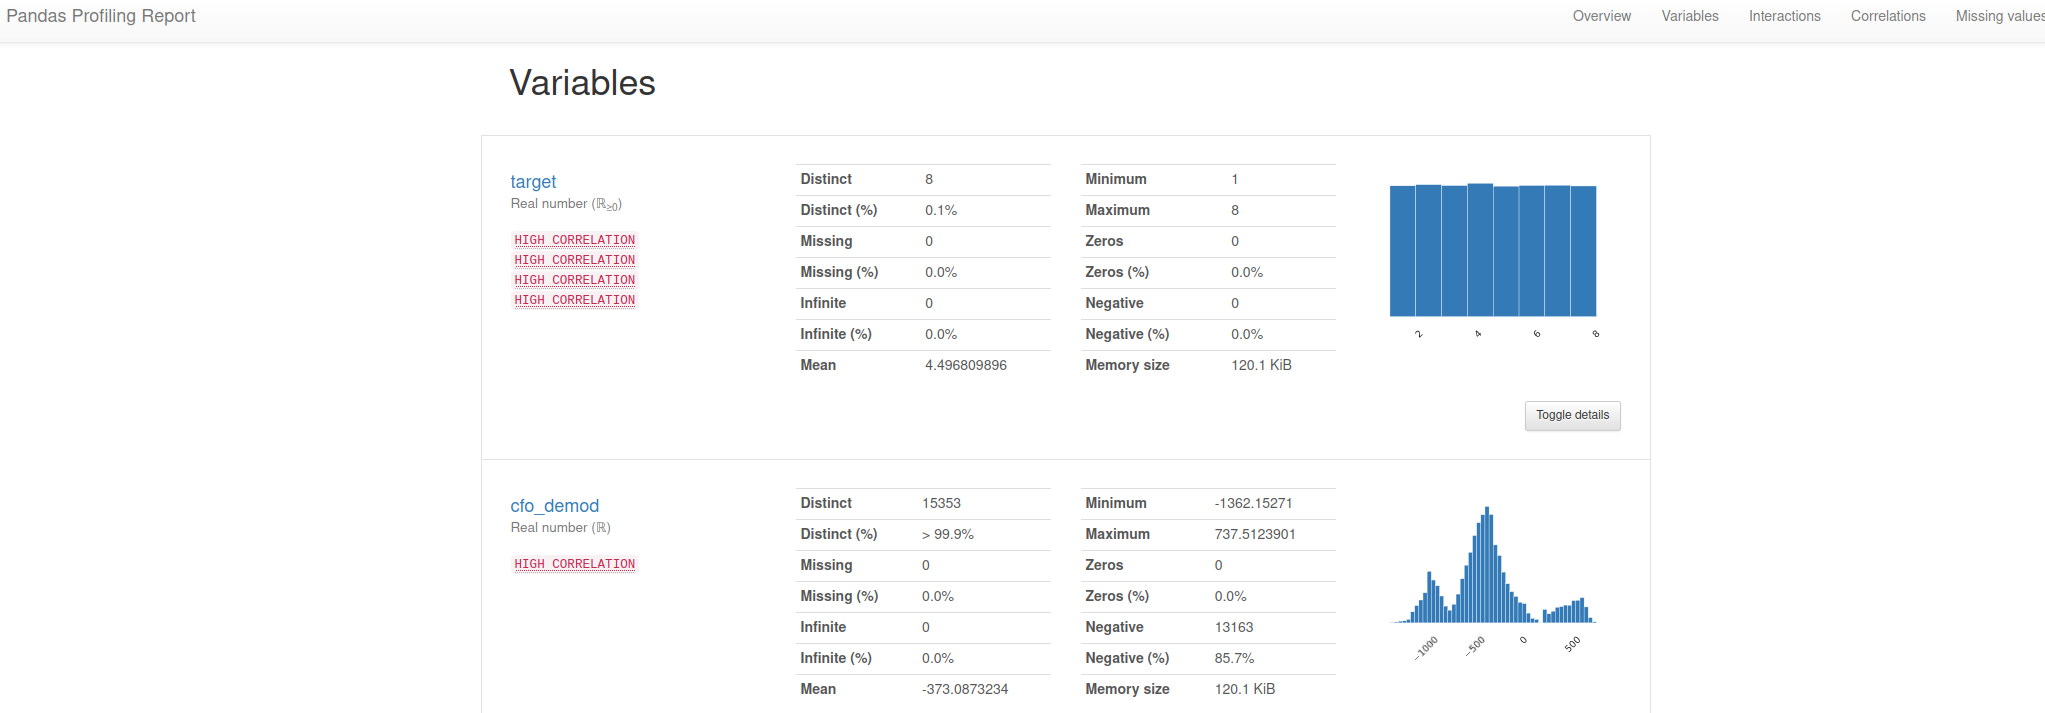

Export the EDA report as html for easier access

In [54]:
eda.to_file(output_file='eda.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

View the EDA under following [link](http://htmlpreview.github.io/?https://github.com/KristynaPijackova/Exercises/blob/main/eda.html)

http://htmlpreview.github.io/?https://github.com/KristynaPijackova/Exercises/blob/main/eda.html

Some general info about the data

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15360 entries, 0 to 15359
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   target     15360 non-null  int64  
 1   cfo_demod  15360 non-null  float64
 2   gain_imb   15360 non-null  float64
 3   iq_imb     15360 non-null  float64
 4   or_off     15360 non-null  float64
 5   quadr_err  15360 non-null  float64
 6   ph_err     15360 non-null  float64
 7   mag_err    15360 non-null  float64
 8   evm        15360 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.1 MB


In [56]:
columns = df.columns
columns

Index(['target', 'cfo_demod', 'gain_imb', 'iq_imb', 'or_off', 'quadr_err',
       'ph_err', 'mag_err', 'evm'],
      dtype='object')

In [57]:
df.max(axis=0)

target         8.000000
cfo_demod    737.512390
gain_imb       0.176385
iq_imb       -28.422335
or_off       -26.306427
quadr_err      3.340285
ph_err        11.439541
mag_err       10.595811
evm           19.152971
dtype: float64

In [58]:
df.min(axis=0)

target          1.000000
cfo_demod   -1362.152710
gain_imb       -0.104031
iq_imb        -56.249794
or_off        -40.763126
quadr_err      -4.318169
ph_err          0.855716
mag_err         0.387086
evm             1.645375
dtype: float64

Let's have a look if the classes are balanced

In [72]:
y_train['target'].value_counts()

4    1949
2    1929
7    1920
6    1917
3    1916
1    1912
8    1910
5    1907
Name: target, dtype: int64

## Data Preprocessing 🖊

Min Max Scaling to normalize the data -> fit on training set

In [62]:
X = pd.DataFrame(x_train)
X_val = X.values
X_col = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_val)
X = pd.DataFrame(x_scaled, columns=X_col)

In [64]:
X.head(5)

cfo_demod  gain_imb    iq_imb    or_off  quadr_err    ph_err   mag_err  \
0   0.930809  0.542445  0.760654  0.844057   0.824101  0.023830  0.109756   
1   0.599548  0.299964  0.945212  0.343402   0.088250  0.035936  0.230634   
2   0.371403  0.500723  0.867960  0.612692   0.934132  0.040292  0.171717   
3   0.348409  0.598966  0.648047  0.738686   0.739638  0.028263  0.069194   
4   0.450846  0.172137  0.972746  0.287901   0.046307  0.060769  0.315578   

        evm  
0  0.044470  
1  0.103537  
2  0.078146  
3  0.034793  
4  0.150866

Apply the scaling to test data as well

In [67]:
X_test = pd.DataFrame(x_test)
X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=X_col)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [68]:
X_test.head(5)

cfo_demod  gain_imb    iq_imb    or_off  quadr_err    ph_err   mag_err  \
0   0.894650  0.570373  0.772649  0.876895   0.833430  0.029323  0.111813   
1   0.433058  0.695725  0.874451  0.807288   0.935071  0.036557  0.162306   
2   0.907637  0.610887  0.788368  0.855479   0.845950  0.016617  0.120377   
3   0.309924  0.377875  0.935928  0.336706   0.101882  0.038225  0.215412   
4   0.213919  0.566040  0.889906  0.529324   0.959719  0.046110  0.179788   

        evm  
0  0.051205  
1  0.075908  
2  0.044676  
3  0.097395  
4  0.088786

In [78]:
y = y_train['target']

The targets are indexed from 1... let's change that and index them from 0

In [87]:
y = y-1

0        4
1        0
2        5
3        2
4        1
        ..
15355    2
15356    7
15357    6
15358    6
15359    4
Name: target, Length: 15360, dtype: int64

In [88]:
num_cls = len(y.unique())
num_cls

8

## Train MLP Model 🏋

Let's build a base of a model for hyperparameter tuning - the model can have from 1 up to 3 dense layers with a number of nodes from a list of following values [64, 128, 256, 512, 1024] and some of following activations ['swish', 'relu', 'sigmoid']. Optionaly, it can contain dropout layer with a dropout rate from 0.2 to 0.8 with step 0.2.

In [89]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(
            layers.Dense(
                # units = hp.Int(f'units_{i}', min_value=16, max_value=256, step=32),
                units = hp.Choice(f'units_{i}', [64, 128, 256, 512, 1024]),
                activation = hp.Choice('activation', ['swish', 'relu', 'sigmoid'])))
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=hp.Float("dr", min_value=0.2, max_value=0.8, step=0.2)))
    model.add(Dense(num_cls, activation='softmax'))
    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model    

In [90]:
hypermodel = build_model(keras_tuner.HyperParameters())

Now that we have the model with tunable parameters ready, we'll implement some tuner - you can choose from random search, bayesioan optimization or hyperband. 

Here, I chose a bayesian optimization, which is a method that builds a probability model of an objective function that will try to make smarter choices for next set of hyperparameters. 

In [91]:
bayes_tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=50,
    num_initial_points=None,
    alpha=0.0001,
    beta=2.6,
    seed=None,
    overwrite=True, 
    directory='/content/hp_tuning_bayes',
    project_name='cifar10_hp_nn_bayes',
)

In [92]:
bayes_tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512, 1024], 'ordered': True}
activation (Choice)
{'default': 'swish', 'conditions': [], 'values': ['swish', 'relu', 'sigmoid'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [93]:
bayes_tuner.search(X, y, epochs=10, batch_size=32, validation_split = 0.2)

Trial 50 Complete [00h 01m 16s]
val_accuracy: 0.9970703125

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 26m 16s


In [94]:
# Get the top 2 models.
models = bayes_tuner.get_best_models(num_models=5)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 8))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 1024)              132096    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 141,448
Trainable params: 141,448
Non-trainable params: 0
_________________________________________________________________


In [95]:
for h_param in [f"units_{i}" for i in range(1,3)] + ['activation'] + ['lr']:
  print(h_param, bayes_tuner.get_best_hyperparameters()[0].get(h_param))

units_1 1024
units_2 64
activation relu
lr 0.005501265000430241


In [97]:
history = best_model.fit(X, y, epochs=3, batch_size=256, validation_split = 0.2)


Epoch 1/3
48/48 [==============================] - 2s 18ms/step - loss: 8.0880e-04 - accuracy: 0.9998 - val_loss: 3.3150e-04 - val_accuracy: 1.0000
Epoch 2/3
48/48 [==============================] - 1s 16ms/step - loss: 6.0722e-04 - accuracy: 0.9999 - val_loss: 2.2426e-04 - val_accuracy: 1.0000
Epoch 3/3
48/48 [==============================] - 1s 13ms/step - loss: 9.9192e-04 - accuracy: 0.9998 - val_loss: 2.4062e-04 - val_accuracy: 1.0000


In [98]:
score = best_model.evaluate(X, y, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

Test loss: 0.00020448357099667192
Test accuracy: 100.0 %


## Save model ⬇

In [ ]:
best_model.save('/content/')

Zip folder with fine tuned HPs results

In [ ]:
!zip -r '/content/hp_tuning.zip' '/content/hp_tuning_bayes'

### Model from submission #1 🥈

In [ ]:
model = keras.Sequential()
model.add(layers.Dense(256, activation='swish'))
model.add(layers.Dense(256, activation='swish'))
model.add(layers.Dense(256, activation='swish'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0051),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
model.build(input_shape=(None, 8))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 256)               2304      
                                                                 
 dense_26 (Dense)            (None, 256)               65792     
                                                                 
 dense_27 (Dense)            (None, 256)               65792     
                                                                 
 dense_28 (Dense)            (None, 9)                 2313      
                                                                 
Total params: 136,201
Trainable params: 136,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X, y, epochs=20, batch_size=256, validation_split = 0.2)


Epoch 1/20
48/48 [==============================] - 4s 39ms/step - loss: 0.5160 - accuracy: 0.8171 - val_loss: 0.0896 - val_accuracy: 0.9723
Epoch 2/20
48/48 [==============================] - 1s 19ms/step - loss: 0.0537 - accuracy: 0.9830 - val_loss: 0.0625 - val_accuracy: 0.9782
Epoch 3/20
48/48 [==============================] - 1s 19ms/step - loss: 0.0395 - accuracy: 0.9871 - val_loss: 0.0451 - val_accuracy: 0.9821
Epoch 4/20
48/48 [==============================] - 1s 13ms/step - loss: 0.0345 - accuracy: 0.9889 - val_loss: 0.0249 - val_accuracy: 0.9938
Epoch 5/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0547 - accuracy: 0.9807 - val_loss: 0.1058 - val_accuracy: 0.9626
Epoch 6/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0230 - accuracy: 0.9929 - val_loss: 0.0172 - val_accuracy: 0.9974
Epoch 7/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0111 - accuracy: 0.9971 - val_loss: 0.0154 - val_accuracy: 0.9948
Epoch 8/20
48

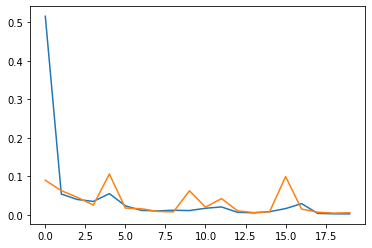

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

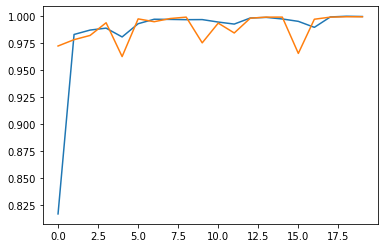

In [ ]:
bplt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
score = model.evaluate(X, y, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

Test loss: 0.002075497293844819
Test accuracy: 99.9804675579071 %


## Get test labels 🏷

Get predictions on the test data

In [126]:
pred = best_model.predict(X_test)
indices = [[i,np.argmax(v)+1] for i,v in enumerate(pred)]
# subset_of_wrongly_predicted = [x_test[i] for i in indices ]

120/120 [==============================] - 0s 2ms/step


In [127]:
y_test = pd.DataFrame(indices, columns=['id', 'target'])
y_test

id  target
0        0       5
1        1       8
2        2       5
3        3       1
4        4       6
...    ...     ...
3835  3835       7
3836  3836       1
3837  3837       2
3838  3838       3
3839  3839       1

[3840 rows x 2 columns]

Save predicted labels to csv

In [104]:
y_test.to_csv('y_test.csv', index=False)

# Train SVM Model 🏋

In [105]:
from sklearn import svm

In [107]:
clf = svm.SVC()
clf.fit(X, y)

SVC()

In [120]:
y_test_svm = clf.predict(X_test)

In [123]:
indices = [[i,v+1] for i,v in enumerate(y_test_svm)]

In [130]:
y_test_svm = pd.DataFrame(indices, columns=['id_svm', 'target_svm'])
y_test_svm

id_svm  target_svm
0          0           5
1          1           8
2          2           5
3          3           1
4          4           6
...      ...         ...
3835    3835           7
3836    3836           1
3837    3837           2
3838    3838           3
3839    3839           1

[3840 rows x 2 columns]

# Compare results of MLP and SVM 🍏🍐

In [136]:
df = y_test.join(y_test_svm)

In [137]:
df.head(5)

id  target  id_svm  target_svm
0   0       5       0           5
1   1       8       1           8
2   2       5       2           5
3   3       1       3           1
4   4       6       4           6

Let us check how does the results overlap...

In [144]:
df['compare'] = df.apply(lambda x: True if x['target'] ==
                     x['target_svm'] else False, axis=1)

And it seems that they get the same results...

In [145]:
df['compare'].value_counts()

True    3840
Name: compare, dtype: int64